In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import alexandria as alx
from typing import Tuple
from pathlib import Path
from datetime import datetime

In [23]:
exec_start = datetime.now()
alx.random.set_seeds(416019652,
                        'all')
output_dir = Path(
    '/',
    'workspace',
    'data',
    'initialization_variation_' + exec_start.strftime('%Y_%m_%d_%H_%M_%S'))
output_dir.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {output_dir}')

Output directory: /workspace/data/initialization_variation_2024_10_12_17_33_34


In [3]:
def get_minist_dataset(val_pct: float) -> Tuple[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset], tfds.core.DatasetInfo]:
    """
    Returns the MNIST dataset split into validation, training and test sets, in this order.

    Parameters
    ----------
    val_pct : float
        Percentage of the training set to use for validation.

    Returns
    -------
    Tuple[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset], tfds.core.DatasetInfo]
        The datasets and the dataset info.
    """
    datasets, info = tfds.load(
        'mnist',
        split=[f'train[:{val_pct}%]', f'train[{val_pct}%:]', 'test'],
        with_info=True,
        as_supervised=True,
        shuffle_files=True
    )
    for i in range(len(datasets)):
        datasets[i] = datasets[i].map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y, 10)))
        datasets[i] = datasets[i].batch(32)
    return datasets, info

In [4]:
def get_mlp_model(input_shape, output_shape, hidden_units=[16, 16], internal_activation='relu'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    for units in hidden_units:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def fit_model(model, train_data, val_data, epochs):
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, mode='min')
    ]
    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=val_data,
                        callbacks=callbacks)
    return history

In [5]:
(val_ds, train_ds, test_ds), info = get_minist_dataset(20)
model_input_shape = info.features['image'].shape
info

2024-10-12 15:57:42.878710: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/workspace/data/tensorflow-datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [6]:
histories=list()
models = list()
n_inits = 10
for init in range(n_inits):
    print(f'RUNNING INIT {init}')
    model = get_mlp_model(
        input_shape=model_input_shape,
        output_shape=info.features['label'].num_classes,
        hidden_units=[8]
    )
    model.summary()
    history_callback = fit_model(model, train_ds, val_ds, epochs=100)
    history_dict = {
        'init': init,
    }
    history_dict.update(history_callback.history)
    histories.append(history_dict)
    models.append(model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RUNNING INIT 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7059 - loss: 0.9742 - val_accuracy: 0.8979 - val_loss: 0.3610
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9022 - loss: 0.3424 - val_accuracy: 0.9082 - val_loss: 0.3171
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9129 - loss: 0.3035 - val_accuracy: 0.9138 - val_loss: 0.3008
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9190 - loss: 0.2844 - val_accuracy: 0.9178 - val_loss: 0.2910
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9214 - loss: 0.2713 - val_accuracy: 0.9192 - val_loss: 0.2849
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9242 - loss: 0.2616 - val_accuracy: 0.9203 - val_loss: 0.2809
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9267 - loss: 0.2542 - val_accuracy: 0.9219 - val_loss: 0.2782
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9283 - loss: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6727 - loss: 1.0628 - val_accuracy: 0.8960 - val_loss: 0.3826
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3584 - val_accuracy: 0.9078 - val_loss: 0.3305
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9111 - loss: 0.3123 - val_accuracy: 0.9128 - val_loss: 0.3104
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9179 - loss: 0.2909 - val_accuracy: 0.9153 - val_loss: 0.2990
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9215 - loss: 0.2775 - val_accuracy: 0.9160 - val_loss: 0.2920
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2676 - val_accuracy: 0.9158 - val_loss: 0.2872
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9263 - loss: 0.2598 - val_accuracy: 0.9176 - val_loss: 0.2837
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9288 - loss: 0

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6645 - loss: 1.0535 - val_accuracy: 0.8984 - val_loss: 0.3526
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9044 - loss: 0.3394 - val_accuracy: 0.9133 - val_loss: 0.3013
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9184 - loss: 0.2915 - val_accuracy: 0.9189 - val_loss: 0.2852
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9229 - loss: 0.2715 - val_accuracy: 0.9205 - val_loss: 0.2777
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9262 - loss: 0.2598 - val_accuracy: 0.9215 - val_loss: 0.2746
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9280 - loss: 0.2518 - val_accuracy: 0.9224 - val_loss: 0.2728
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9299 - loss: 0.2458 - val_accuracy: 0.9222 - val_loss: 0.2714
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9315 - loss: 0

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7158 - loss: 0.9919 - val_accuracy: 0.8905 - val_loss: 0.3850
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3740 - val_accuracy: 0.9014 - val_loss: 0.3440
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9062 - loss: 0.3360 - val_accuracy: 0.9040 - val_loss: 0.3295
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9119 - loss: 0.3183 - val_accuracy: 0.9072 - val_loss: 0.3223
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9152 - loss: 0.3073 - val_accuracy: 0.9092 - val_loss: 0.3176
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9183 - loss: 0.2993 - val_accuracy: 0.9108 - val_loss: 0.3140
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9196 - loss: 0.2931 - val_accuracy: 0.9120 - val_loss: 0.3112
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9210 - loss: 0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7111 - loss: 0.9817 - val_accuracy: 0.8876 - val_loss: 0.3895
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3651 - val_accuracy: 0.9032 - val_loss: 0.3422
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9070 - loss: 0.3231 - val_accuracy: 0.9093 - val_loss: 0.3243
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9138 - loss: 0.3022 - val_accuracy: 0.9118 - val_loss: 0.3138
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9182 - loss: 0.2882 - val_accuracy: 0.9142 - val_loss: 0.3069
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9215 - loss: 0.2785 - val_accuracy: 0.9147 - val_loss: 0.3022
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9241 - loss: 0.2713 - val_accuracy: 0.9153 - val_loss: 0.2986
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9265 - loss: 0

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7056 - loss: 0.9708 - val_accuracy: 0.9046 - val_loss: 0.3412
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9075 - loss: 0.3277 - val_accuracy: 0.9121 - val_loss: 0.3110
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9160 - loss: 0.2978 - val_accuracy: 0.9154 - val_loss: 0.3019
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9196 - loss: 0.2832 - val_accuracy: 0.9156 - val_loss: 0.2976
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9232 - loss: 0.2739 - val_accuracy: 0.9177 - val_loss: 0.2950
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2669 - val_accuracy: 0.9208 - val_loss: 0.2933
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9258 - loss: 0.2610 - val_accuracy: 0.9195 - val_loss: 0.2920
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9274 - loss: 0

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6864 - loss: 1.0103 - val_accuracy: 0.9023 - val_loss: 0.3490
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9063 - loss: 0.3333 - val_accuracy: 0.9118 - val_loss: 0.3169
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9146 - loss: 0.2992 - val_accuracy: 0.9143 - val_loss: 0.3060
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9196 - loss: 0.2829 - val_accuracy: 0.9158 - val_loss: 0.3002
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2725 - val_accuracy: 0.9175 - val_loss: 0.2970
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9250 - loss: 0.2649 - val_accuracy: 0.9184 - val_loss: 0.2952
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9269 - loss: 0.2588 - val_accuracy: 0.9197 - val_loss: 0.2936
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9283 - loss: 0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7013 - loss: 0.9782 - val_accuracy: 0.8873 - val_loss: 0.3825
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8930 - loss: 0.3682 - val_accuracy: 0.9050 - val_loss: 0.3291
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9099 - loss: 0.3185 - val_accuracy: 0.9118 - val_loss: 0.3090
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9168 - loss: 0.2950 - val_accuracy: 0.9146 - val_loss: 0.2991
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9211 - loss: 0.2810 - val_accuracy: 0.9166 - val_loss: 0.2937
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9238 - loss: 0.2716 - val_accuracy: 0.9178 - val_loss: 0.2902
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9252 - loss: 0.2646 - val_accuracy: 0.9180 - val_loss: 0.2881
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9266 - loss: 0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6923 - loss: 0.9945 - val_accuracy: 0.8904 - val_loss: 0.3733
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.3533 - val_accuracy: 0.9080 - val_loss: 0.3260
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9111 - loss: 0.3091 - val_accuracy: 0.9134 - val_loss: 0.3092
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9179 - loss: 0.2882 - val_accuracy: 0.9165 - val_loss: 0.3006
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9213 - loss: 0.2754 - val_accuracy: 0.9174 - val_loss: 0.2958
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9238 - loss: 0.2666 - val_accuracy: 0.9187 - val_loss: 0.2925
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9259 - loss: 0.2596 - val_accuracy: 0.9192 - val_loss: 0.2897
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9280 - loss: 0

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6500 - loss: 1.1089 - val_accuracy: 0.8818 - val_loss: 0.4165
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8886 - loss: 0.3946 - val_accuracy: 0.8971 - val_loss: 0.3664
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9010 - loss: 0.3499 - val_accuracy: 0.9025 - val_loss: 0.3462
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9087 - loss: 0.3279 - val_accuracy: 0.9052 - val_loss: 0.3339
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9122 - loss: 0.3135 - val_accuracy: 0.9068 - val_loss: 0.3262
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9153 - loss: 0.3032 - val_accuracy: 0.9097 - val_loss: 0.3210
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9177 - loss: 0.2953 - val_accuracy: 0.9112 - val_loss: 0.3167
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9189 - loss: 0

In [27]:
histories_filename = output_dir / 'histories.json'
with histories_filename.open('w') as f:
    json.dump(histories, f, indent=4)
for init in range(n_inits):
    models[init].save(str(output_dir / f'model_{init}.keras'))

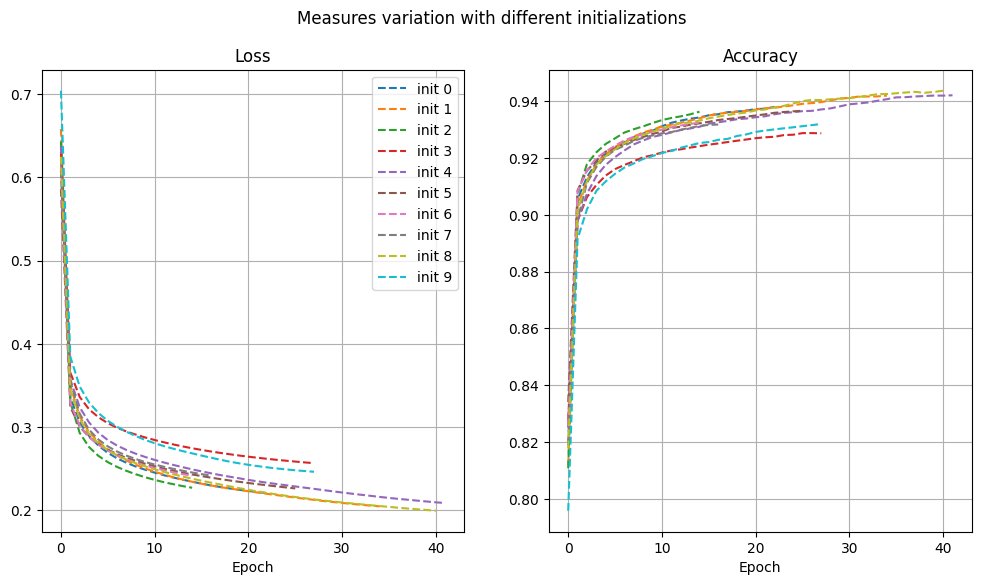

In [28]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
loss_ax = axes[0]
acc_ax = axes[1]
loss_ax.set_title('Loss')
acc_ax.set_title('Accuracy')
loss_ax.set_xlabel('Epoch')
acc_ax.set_xlabel('Epoch')
loss_ax.grid()
acc_ax.grid()
for history in histories:
    loss_ax.plot(history['loss'], label=f'init {history["init"]}', linestyle='--')
    acc_ax.plot(history['accuracy'], label=f'init {history["init"]}', linestyle='--')
loss_ax.legend()
fig.suptitle('Measures variation with different initializations')
fig.savefig(str(output_dir / 'measures_variation.png'), dpi=300)
